In [1]:
from src.sec_8k_preprocess import load_8k_filings, parse_8k_filing
import polars as pl
import hvplot.polars
%load_ext autoreload
%autoreload 2

In [71]:
df_8k = load_8k_filings()
df_8k.head()

 Parquet file exists at data/preprocessed/submissions_8k.parquet. Reading...


cik_int,company_name,form,accession,filing_date,report_date,acceptance_datetime,act,file_number,film_number,items,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,acceptance_date,accession_no_dash,url_txt
str,str,str,str,date,date,datetime[μs],str,str,str,str,i64,i64,i64,str,str,date,str,str
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950131-95-002984""",1995-10-27,1995-10-18,null,"""""","""001-06244""","""95584984""","""5,7""",8451,0,0,"""""","""FORM 8-K""",null,"""000095013195002984""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950109-95-002831""",1995-07-28,1995-06-30,null,"""""","""001-06244""","""95557157""","""5""",116160,0,0,"""""","""FORM 8-K""",null,"""000095010995002831""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000890613-95-000092""",1995-07-11,1995-07-07,null,"""""","""001-06244""","""95553269""","""5,7""",27032,0,0,"""""","""FORM 8-K""",null,"""000089061395000092""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950123-95-001123""",1995-04-25,1995-04-10,null,"""""","""001-06244""","""95531061""","""5,7""",7025,0,0,"""""","""FORM 8-K CURRENT REPORT""",null,"""000095012395001123""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950123-95-001008""",1995-04-13,1995-04-12,null,"""""","""001-06244""","""95528563""","""5,7""",6741,0,0,"""""","""FORM 8-K""",null,"""000095012395001008""","""https://www.sec.gov/Archives/e…"


In [72]:
df_8k = df_8k.with_columns((pl.col('filing_date') - pl.col('report_date')).alias('days_between_report_and_filing'))

In [73]:
# Filter to only include filings from 2004 onwards
df_8k = df_8k.filter(pl.col('report_date') >= pl.datetime(2004, 1, 1))

In [74]:
df_8k = df_8k.with_columns(pl.col("report_date").dt.year().alias("report_year"))
yearly_counts = df_8k.group_by('report_year').agg(pl.len().alias('count'))

In [ ]:
yearly_counts.hvplot.bar(
    x="report_year",
    y="count",
    title="Yearly Counts",
    xlabel="Year",
    ylabel="Number of Reports",
    width=700,
    height=400,
    legend="top_right"
)

:Bars   [report_year]   (count)

In [76]:
# Filter to only include filings where the report date is within 30 days before the filing date
df_8k = df_8k.with_columns(
    (pl.col("days_between_report_and_filing").dt.total_seconds() / 86400)#Convert seconds to days
    .alias("days_between_report_and_filing_days")
).filter(
    pl.col("days_between_report_and_filing_days").is_between(0, 30)#Keep only filings where the report date is within 30 days before the filing date
)

In [77]:
df_8k.select(pl.col('days_between_report_and_filing')).describe()

statistic,days_between_report_and_filing
str,str
"""count""","""1474688"""
"""null_count""","""0"""
"""mean""","""2 days, 8:12:39.621560"""
"""std""",null
"""min""","""0:00:00"""
"""25%""","""0:00:00"""
"""50%""","""1 day, 0:00:00"""
"""75%""","""4 days, 0:00:00"""
"""max""","""30 days, 0:00:00"""


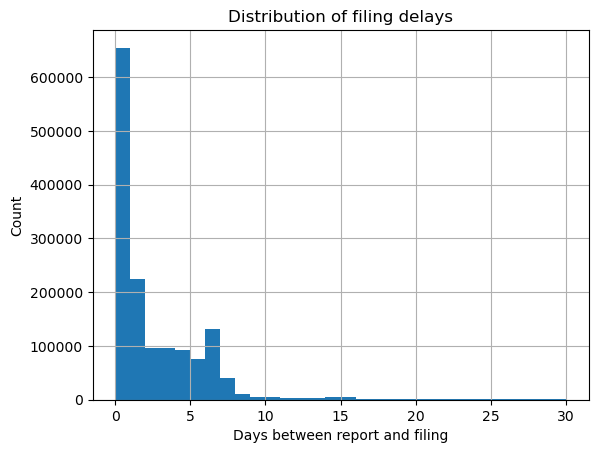

In [78]:
import matplotlib.pyplot as plt

df_8k.select(pl.col("days_between_report_and_filing_days")).to_pandas().hist(bins=30)
plt.xlabel("Days between report and filing")
plt.ylabel("Count")
plt.title("Distribution of filing delays")
plt.show()

In [79]:
# Keep only filings where the report date is at least 1 day before the filing date
df_8k = df_8k.filter(pl.col("days_between_report_and_filing_days") >= 1)

In [80]:
from src.CRSP_ITI_FNSPID_merge import process_crsp_iti_fnspid_dataset
df = process_crsp_iti_fnspid_dataset()

[INFO] Final dataset already exists at /Users/williamjallot/Desktop/semester_project/news-based-asset-pricing/data/merged/crsp_iti_fnspid.csv. Loading from disk...


In [146]:
# pip install wrds pandas
import pandas as pd
import wrds
from src.crsp_preprocess import connect_to_wrds

# ---------------------------
# Connection
# ---------------------------
db = connect_to_wrds()  

# ---------------------------
# Pull source tables
# ---------------------------

comp_company = db.raw_sql("""
    SELECT gvkey, cik, conm
    FROM comp.company
""")

ccm = db.raw_sql("""
    SELECT gvkey, lpermno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
""")

# --- clean & filter ---
ccm_filt = (
    ccm.rename(columns={"lpermno": "permno"})
        .dropna(subset=["permno"])
        .assign(
            linkdt   = pd.to_datetime(ccm["linkdt"]).fillna(pd.Timestamp("1900-01-01")),
            linkenddt= pd.to_datetime(ccm["linkenddt"]).fillna(pd.Timestamp("2099-12-31"))
        )
)

# keep reliable/primary links (common practice)
ccm_best = ccm_filt.loc[
    ccm_filt["linktype"].isin(["LU", "LC"])
    & ccm_filt["linkprim"].isin(["P", "C"])
]


# Ensure dates are proper; treat open-ended linkenddt as far-future
for col in ["linkdt", "linkenddt"]:
    ccm_filt[col] = pd.to_datetime(ccm_filt[col])

ccm_filt["linkenddt"] = ccm_filt["linkenddt"].fillna(pd.Timestamp("2099-12-31"))

# ---------------------------
# Build a base CIK–PERMNO link table (time-aware)
# ---------------------------
cik_gvkey = comp_company.dropna(subset=["cik"]).drop_duplicates(subset=["gvkey", "cik"])
cik_permno = (
    cik_gvkey.merge(ccm_filt[["gvkey", "permno", "linkdt", "linkenddt"]], on="gvkey", how="inner")
)

# At this point, cik_permno contains:
#   cik, gvkey, permno, linkdt, linkenddt  (validity window for the mapping)

# ---------------------------
# Helper: map a filings DataFrame (with CIK and date) to PERMNO as of that date
def map_filings_to_permno(filings_df: pl.DataFrame, cik_permno: pl.DataFrame,
                                 cik_col: str = "cik", date_col: str = "filing_date") -> pl.DataFrame:
    """
    Map filings (CIK, date) to PERMNO and GVKEY using a Polars DataFrame join.
    
    Parameters
    ----------
    filings_df : pl.DataFrame
        DataFrame containing at least the CIK and filing_date columns.
    cik_permno : pl.DataFrame
        Mapping table with columns ['cik', 'gvkey', 'permno', 'linkdt', 'linkenddt'].
    cik_col : str
        Column name of the CIK in filings_df.
    date_col : str
        Column name of the filing date in filings_df.

    Returns
    -------
    pl.DataFrame
        filings_df with matched 'permno' and 'gvkey' columns (filtered by valid link window).
    """
    cik_permno = pl.from_dataframe(cik_permno)
    
    df = filings_df.with_columns([
        pl.col(cik_col).cast(pl.Utf8).str.strip_chars()
    ])

    link = cik_permno.with_columns([
        pl.col("cik").cast(pl.Utf8).str.strip_chars(),
        pl.col("linkdt").cast(pl.Date),
        pl.col("linkenddt").cast(pl.Date)
    ])

    # Join filings with cik–permno mapping
    merged = df.join(link, left_on=cik_col, right_on="cik", how="left")

    # Filter by date window
    merged = merged.filter(
        (pl.col(date_col) >= pl.col("linkdt")) &
        (pl.col(date_col) <= pl.col("linkenddt"))
    )

    # Sort and deduplicate to keep most recent link (largest linkdt)
    merged = merged.sort(["gvkey", "permno", "linkdt"])
    merged = merged.unique(subset=[cik_col, date_col], keep="last")

    # Return only relevant columns
    keep_cols = list(filings_df.columns) + ["permno", "gvkey"]
    return merged.select(keep_cols)



mapped = map_filings_to_permno(df_8k, cik_permno=cik_permno, cik_col="cik_int", date_col="filing_date")
print(mapped.head())

Connecting to WRDS as williamandwing...
postgresql://williamandwing:@wrds-pgdata.wharton.upenn.edu:9737/wrds
Loading library list...
Done
shape: (0, 24)
┌─────────┬──────────────┬──────┬───────────┬───┬─────────────┬───────────────────┬────────┬───────┐
│ cik_int ┆ company_name ┆ form ┆ accession ┆ … ┆ report_year ┆ days_between_repo ┆ permno ┆ gvkey │
│ ---     ┆ ---          ┆ ---  ┆ ---       ┆   ┆ ---         ┆ rt_and_filing…    ┆ ---    ┆ ---   │
│ str     ┆ str          ┆ str  ┆ str       ┆   ┆ i32         ┆ ---               ┆ f64    ┆ str   │
│         ┆              ┆      ┆           ┆   ┆             ┆ f64               ┆        ┆       │
╞═════════╪══════════════╪══════╪═══════════╪═══╪═════════════╪═══════════════════╪════════╪═══════╡
└─────────┴──────────────┴──────┴───────────┴───┴─────────────┴───────────────────┴────────┴───────┘


In [148]:
cik_permno = pl.from_dataframe(cik_permno)

filings_df = df_8k
cik_col = 'cik_int'
date_col = 'filing_date'

df = filings_df.with_columns([
    pl.col(cik_col).cast(pl.Utf8).str.strip_chars()
])

link = cik_permno.with_columns([
    pl.col("cik").cast(pl.Utf8).str.strip_chars(),
    pl.col("linkdt").cast(pl.Date),
    pl.col("linkenddt").cast(pl.Date)
])

# Join filings with cik–permno mapping
merged = df.join(link, left_on=cik_col, right_on="cik", how="left")

# Filter by date window
merged = merged.filter(
    (pl.col(date_col) >= pl.col("linkdt")) &
    (pl.col(date_col) <= pl.col("linkenddt"))
)

# Sort and deduplicate to keep most recent link (largest linkdt)
merged = merged.sort(["gvkey", "permno", "linkdt"])
merged = merged.unique(subset=[cik_col, date_col], keep="last")

# Return only relevant columns
keep_cols = list(filings_df.columns) + ["permno", "gvkey"]
merged.select(keep_cols)


cik_int,company_name,form,accession,filing_date,report_date,acceptance_datetime,act,file_number,film_number,items,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,acceptance_date,accession_no_dash,url_txt,days_between_report_and_filing,report_year,days_between_report_and_filing_days,permno,gvkey
str,str,str,str,date,date,datetime[μs],str,str,str,str,i64,i64,i64,str,str,date,str,str,duration[μs],i32,f64,f64,str


In [150]:
df = df.with_columns(pl.col('cik_int').str.len_chars().alias('length_cik'))

In [151]:
df = df.with_columns(
    (pl.lit("0").repeat_by(10 - pl.col('length_cik'))
    .list.join("")
    +  pl.col("cik_int").cast(pl.Utf8)).alias('cleaned_cik')
)

In [154]:
merged = df.join(link, left_on='cleaned_cik',right_on="cik", how="left")

In [155]:
merged.filter(pl.col("permno").is_null())

cik_int,company_name,form,accession,filing_date,report_date,acceptance_datetime,act,file_number,film_number,items,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,acceptance_date,accession_no_dash,url_txt,days_between_report_and_filing,report_year,days_between_report_and_filing_days,length_cik,cleaned_cik,gvkey,conm,permno,linkdt,linkenddt
str,str,str,str,date,date,datetime[μs],str,str,str,str,i64,i64,i64,str,str,date,str,str,duration[μs],i32,f64,u32,str,str,str,f64,date,date
"""4458""","""U HAUL INTERNATIONAL INC""","""8-K""","""0000004457-06-000039""",2006-12-22,2006-12-19,null,"""34""","""002-38498""","""061297568""","""5.02""",24453,0,0,"""departureofdirector.htm""","""DEPARTURE OF DIRECTOR""",null,"""000000445706000039""","""https://www.sec.gov/Archives/e…",3d,2006,3.0,4,"""0000004458""",null,null,null,null,null
"""4458""","""U HAUL INTERNATIONAL INC""","""8-K""","""0000004457-06-000019""",2006-08-23,2006-08-21,null,"""34""","""002-38498""","""061049408""","""1.01,2.03,9.01""",450866,0,0,"""amendedhybrid.htm""","""AMENDMENT OF HYBRID REAL ESTAT…",null,"""000000445706000019""","""https://www.sec.gov/Archives/e…",2d,2006,2.0,4,"""0000004458""",null,null,null,null,null
"""4458""","""U HAUL INTERNATIONAL INC""","""8-K""","""0000004457-06-000017""",2006-08-16,2006-08-10,null,"""34""","""002-38498""","""061038911""","""2.02,9.01""",408959,0,0,"""conferencecall.htm""","""FISCAL 2007 1ST QUARTER CONFER…",null,"""000000445706000017""","""https://www.sec.gov/Archives/e…",6d,2006,6.0,4,"""0000004458""",null,null,null,null,null
"""4458""","""U HAUL INTERNATIONAL INC""","""8-K""","""0000004457-05-000024""",2005-11-17,2005-11-10,null,"""34""","""002-38498""","""051212072""","""1.01,2.03,9.01""",929032,0,0,"""creditagreement.htm""","""MATERIAL DEFINITIVE AGREEMENT …",null,"""000000445705000024""","""https://www.sec.gov/Archives/e…",7d,2005,7.0,4,"""0000004458""",null,null,null,null,null
"""4458""","""U HAUL INTERNATIONAL INC""","""8-K""","""0000004457-05-000023""",2005-11-16,2005-11-09,null,"""34""","""002-38498""","""051209669""","""2.01,9.01""",310545,0,0,"""conferencecall.htm""","""NOVEMBER 9TH 2ND QUARTER FISCA…",null,"""000000445705000023""","""https://www.sec.gov/Archives/e…",7d,2005,7.0,4,"""0000004458""",null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2091562""","""Morgan Stanley Bank of America…","""8-K""","""0001539497-25-002805""",2025-10-30,2025-10-28,null,"""34""","""333-282944-03""","""251435183""","""8.01,9.01""",25904207,0,0,"""n5366_x9-8k.htm""","""8-K""",null,"""000153949725002805""","""https://www.sec.gov/Archives/e…",2d,2025,2.0,7,"""0002091562""",null,null,null,null,null
"""2089663""","""Capital One Prime Auto Receiva…","""8-K""","""0001193125-25-258375""",2025-10-30,2025-10-28,null,"""34""","""333-286543-01""","""251434951""","""8.01,9.01""",56727,0,0,"""d23514d8k.htm""","""8-K""",null,"""000119312525258375""","""https://www.sec.gov/Archives/e…",2d,2025,2.0,7,"""0002089663""",null,null,null,null,null
"""2089663""","""Capital One Prime Auto Receiva…","""8-K""","""0001193125-25-258363""",2025-10-30,2025-10-28,null,"""34""","""333-286543-01""","""251434857""","""1.01,8.01,9.01""",2245345,0,0,"""d58937d8k.htm""","""8-K""",null,"""000119312525258363""","""https://www.sec.gov/Archives/e…",2d,2025,2.0,7,"""0002089663""",null,null,null,null,null


In [163]:
merged_cleaned = merged.drop_nulls(subset = 'permno')

In [172]:
merged_cleaned = merged_cleaned.select(pl.col('permno'), pl.col('filing_date'),pl.col('report_date'), pl.col('days_between_report_and_filing_days'))

In [175]:
merged_cleaned = merged_cleaned.with_columns(pl.col('permno').cast(pl.Int32))

In [176]:
merged_cleaned

permno,filing_date,report_date,days_between_report_and_filing_days
i32,date,date,f64
14286,2007-05-29,2007-05-22,7.0
14286,2007-04-10,2007-04-07,3.0
14286,2007-03-12,2007-03-09,3.0
14286,2007-02-23,2007-02-21,2.0
14286,2007-02-09,2007-02-08,1.0
…,…,…,…
24806,2025-08-14,2025-07-15,30.0
24806,2025-07-18,2025-07-15,3.0
26002,2025-10-16,2025-10-09,7.0


In [8]:
import polars as pl
import matplotlib.pyplot as plt
import hvplot.polars

from src.sec_8k_preprocess import preprocess_sec_8k
from src.iti_8k_merge import merge_8k_iti

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df_8k = preprocess_sec_8k()
df_8k

 Parquet file exists at data/preprocessed/submissions_8k.parquet. Reading...
Connecting to WRDS as matthiasw...
postgresql://matthiasw:@wrds-pgdata.wharton.upenn.edu:9737/wrds
Loading library list...
Done
Number of rows with missing permno: 0


permno,filing_date,report_date,report_year,days_between_report_and_filing,url_txt
i64,date,date,i32,i32,str
14286,2007-05-29,2007-05-22,2007,7,"""https://www.sec.gov/Archives/e…"
14286,2007-04-10,2007-04-07,2007,3,"""https://www.sec.gov/Archives/e…"
14286,2007-03-12,2007-03-09,2007,3,"""https://www.sec.gov/Archives/e…"
14286,2007-02-23,2007-02-21,2007,2,"""https://www.sec.gov/Archives/e…"
14286,2007-02-09,2007-02-08,2007,1,"""https://www.sec.gov/Archives/e…"
…,…,…,…,…,…
20204,2023-03-20,2023-03-17,2023,3,"""https://www.sec.gov/Archives/e…"
21553,2023-12-01,2023-11-29,2023,2,"""https://www.sec.gov/Archives/e…"
21553,2023-12-01,2023-11-29,2023,2,"""https://www.sec.gov/Archives/e…"


In [10]:
yearly_counts = df_8k.group_by('report_year').agg(pl.len().alias('count'))
yearly_counts.hvplot.bar(
    x="report_year",
    y="count",
    title="Yearly Counts",
    xlabel="Year",
    ylabel="Number of Reports",
    width=700,
    height=400,
    legend="top_right"
)

:Bars   [report_year]   (count)

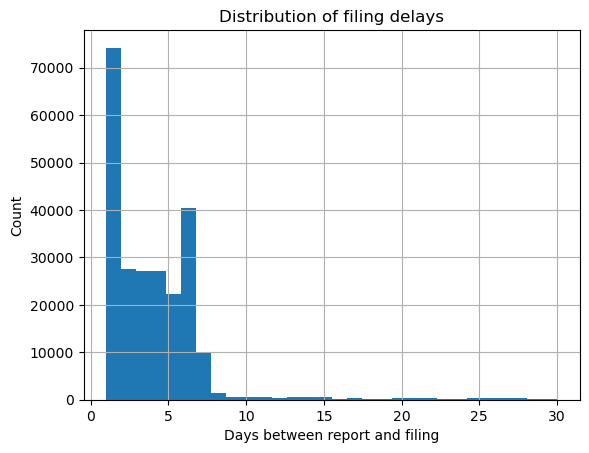

In [11]:
df_8k.select(pl.col("days_between_report_and_filing")).to_pandas().hist(bins=30)
plt.xlabel("Days between report and filing")
plt.ylabel("Count")
plt.title("Distribution of filing delays")
plt.show()

In [12]:
df_8k_iti = merge_8k_iti()
df_8k_iti

 Parquet file exists at data/preprocessed/submissions_8k.parquet. Reading...
Connecting to WRDS as matthiasw...
postgresql://matthiasw:@wrds-pgdata.wharton.upenn.edu:9737/wrds
Loading library list...
Done
Number of rows with missing permno: 0


permno,report_date,ITI(13D),ITI(impatient),ITI(patient),ITI(insider),ITI(short),filing_date,report_year,days_between_report_and_filing,url_txt
i64,date,f64,f64,f64,f64,f64,date,i32,i32,str
10002,2004-01-02,0.279246,0.4800742,0.136089,0.841966,0.44167,null,null,null,null
10002,2004-01-05,0.305832,0.347955,0.2828667,0.597243,0.368246,null,null,null,null
10002,2004-01-06,0.183781,0.3456269,0.2302857,0.614442,0.359454,null,null,null,null
10002,2004-01-07,0.32034,0.295549,0.076392,0.207949,0.3215582,null,null,null,null
10002,2004-01-08,0.460198,0.452824,0.3918479,0.566814,0.372601,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…
93436,2019-07-25,0.7143043,0.724727,0.542438,0.380394,0.6213029,null,null,null,null
93436,2019-07-26,0.600154,0.5010967,0.610971,0.526966,0.4971562,null,null,null,null
93436,2019-07-29,0.396769,0.59211,0.263118,0.445594,0.5007075,null,null,null,null
